[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1SXHFDqYb2rUZPXstqi1Um92hHolCP-Xo#scrollTo=tLoxtLssN0KV)

In [ ]:
!cp -r "/content/drive/MyDrive/Ecole/Internship/data" "/content/"

In [ ]:
!pip install fasttext -q

import fasttext
import fasttext.util

     |████████████████████████████████| 68 kB 5.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

import gensim
import gensim.downloader as api
from gensim.models import word2vec, KeyedVectors

In [ ]:
def apply_w2v(w2v_model, line):
    result = np.zeros((300,))
    words = line.split(' ')

    for w in words:
        if w in w2v_model:
            result += w2v_model[w]
        else:
            return None
    
    return result / len(words)

In [ ]:
df_fb = pd.read_csv('/content/data/FB15-K-237/train.txt', sep='\t', header=None)
df_fb.columns = ['word1', 'relation', 'word2']
df_fb.head()

,word1,relation,word2
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [ ]:
df_wn_train = pd.read_csv('/content/data/WN18RR/text/train.txt', sep='\t', header=None)
df_wn_train.columns = ['word1', 'relation', 'word2']
df_wn_train.head()

,word1,relation,word2
0,land_reform.n.01,_hypernym,reform.n.01
1,cover.v.01,_derivationally_related_form,covering.n.02
2,botany.n.02,_derivationally_related_form,botanize.v.01
3,kamet.n.01,_instance_hypernym,mountain_peak.n.01
4,question.n.01,_derivationally_related_form,ask.v.01


In [ ]:
df_wn_valid = pd.read_csv('/content/data/WN18RR/text/valid.txt', sep='\t', header=None)
df_wn_valid.columns = ['word1', 'relation', 'word2']

df_wn_test = pd.read_csv('/content/data/WN18RR/text/test.txt', sep='\t', header=None)
df_wn_test.columns = ['word1', 'relation', 'word2']

In [ ]:
df_wn_train.shape, df_wn_valid.shape, df_wn_test.shape

((86835, 3), (3034, 3), (3134, 3))

In [ ]:
df_wn_train['relation'].unique()

array(['_hypernym', '_derivationally_related_form', '_instance_hypernym',
       '_also_see', '_member_meronym', '_synset_domain_topic_of',
       '_has_part', '_member_of_domain_usage', '_member_of_domain_region',
       '_verb_group', '_similar_to'], dtype=object)

In [ ]:
bad_relations = ['_derivationally_related_form', ] # '_verb_group'?
df_wn_train = df_wn_train[~df_wn_train['relation'].isin(bad_relations)]
df_wn_valid = df_wn_valid[~df_wn_valid['relation'].isin(bad_relations)]

In [ ]:
def clean_word(word):
    word = word.split('.')[0]
    word = word.replace('_', ' ')
    return word

In [ ]:
df_wn_train['clean_word1'] = df_wn_train['word1'].apply(lambda x: clean_word(x))
df_wn_train['clean_word2'] = df_wn_train['word2'].apply(lambda x: clean_word(x))

df_wn_valid['clean_word1'] = df_wn_valid['word1'].apply(lambda x: clean_word(x))
df_wn_valid['clean_word2'] = df_wn_valid['word2'].apply(lambda x: clean_word(x))
df_wn_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,word1,relation,word2,clean_word1,clean_word2
0,land_reform.n.01,_hypernym,reform.n.01,land reform,reform
3,kamet.n.01,_instance_hypernym,mountain_peak.n.01,kamet,mountain peak
6,hoist.v.03,_hypernym,raise.v.02,hoist,raise
7,empathy.n.01,_hypernym,sympathy.n.02,empathy,sympathy
8,disengagement.n.02,_hypernym,retreat.n.01,disengagement,retreat


In [ ]:
le = LabelEncoder()
df_wn_train['relation_num'] = le.fit_transform(df_wn_train['relation'].values)
df_wn_valid['relation_num'] = le.transform(df_wn_valid['relation'].values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_wn_train.head()

,word1,relation,word2,clean_word1,clean_word2,relation_num
0,land_reform.n.01,_hypernym,reform.n.01,land reform,reform,2
3,kamet.n.01,_instance_hypernym,mountain_peak.n.01,kamet,mountain peak,3
6,hoist.v.03,_hypernym,raise.v.02,hoist,raise,2
7,empathy.n.01,_hypernym,sympathy.n.02,empathy,sympathy,2
8,disengagement.n.02,_hypernym,retreat.n.01,disengagement,retreat,2


## Word2Vec

In [ ]:
# wv = api.load('word2vec-google-news-300')

# wv.save_word2vec_format('word2_vec_google_news.bin', binary=True)

In [ ]:
# model_negative_path = 'data/GoogleNews-vectors-negative300.bin.gz'

# model_wv_neg = gensim.models.KeyedVectors.load_word2vec_format(model_negative_path, binary=True)

In [ ]:
model_path = 'data/word2_vec_google_news.bin'

model_wv = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
print(model_wv.similarity('car', 'bike'))
print(model_wv.similarity('car', 'gasoline'))

In [ ]:
# print(model_wv.most_similar(positive=['king', 'woman'], negative=['man'])[0][0])

In [ ]:
df_wn_train['word1_w2v_embed'] = df_wn_train['clean_word1'].apply(lambda x: apply_w2v(model_wv, x))
df_wn_train['word2_w2v_embed'] = df_wn_train['clean_word2'].apply(lambda x: apply_w2v(model_wv, x))

df_wn_valid['word1_w2v_embed'] = df_wn_valid['clean_word1'].apply(lambda x: apply_w2v(model_wv, x))
df_wn_valid['word2_w2v_embed'] = df_wn_valid['clean_word2'].apply(lambda x: apply_w2v(model_wv, x))

In [ ]:
df_wn_train.head()

,word1,relation,word2,clean_word1,clean_word2,relation_num,word1_w2v_embed,word2_w2v_embed
0,land_reform.n.01,_hypernym,reform.n.01,land reform,reform,2,"[0.044189453125, 0.018798828125, 0.0234375, 0....","[-0.11669921875, 0.031982421875, -0.1015625, 0..."
3,kamet.n.01,_instance_hypernym,mountain_peak.n.01,kamet,mountain peak,3,None,"[0.0640869140625, 0.015869140625, -0.024085998..."
6,hoist.v.03,_hypernym,raise.v.02,hoist,raise,2,"[-0.138671875, 0.1142578125, -0.279296875, 0.1...","[-0.02783203125, -0.09228515625, -0.134765625,..."
7,empathy.n.01,_hypernym,sympathy.n.02,empathy,sympathy,2,"[0.35546875, -0.1376953125, 0.004730224609375,...","[0.2294921875, -0.126953125, 0.14453125, 0.263..."
8,disengagement.n.02,_hypernym,retreat.n.01,disengagement,retreat,2,"[0.1806640625, -0.09130859375, -0.2734375, 0.2...","[-0.1533203125, 0.07080078125, -0.0791015625, ..."


In [ ]:
df_wn_train_w2v = df_wn_train.dropna()
df_wn_valid_w2v = df_wn_valid.dropna()

In [ ]:
df_wn_train.shape

(57120, 8)

In [ ]:
def get_embeds_matrix(df, column, size):
    embeds = df[column].values
    for i in range(embeds.shape[0]):
        if type(embeds[i]) is not np.ndarray:
            embeds[i] = np.zeros(size)
    embeds = np.stack(embeds)

    return embeds

In [ ]:
# word1_embeds = get_embeds_matrix(df_wn_train, column='word1_w2v_embed', size=300)
# word2_embeds = get_embeds_matrix(df_wn_train, column='word2_w2v_embed', size=300)
word1_embeds = np.stack(df_wn_train_w2v['word1_w2v_embed'].values)
word2_embeds = np.stack(df_wn_train_w2v['word2_w2v_embed'].values)
train_embeds = word1_embeds + word2_embeds

y_train = df_wn_train_w2v['relation_num'].values

In [ ]:
# word1_embeds = get_embeds_matrix(df_wn_valid, column='word1_w2v_embed', size=300)
# word2_embeds = get_embeds_matrix(df_wn_valid, column='word2_w2v_embed', size=300)
word1_embeds = np.stack(df_wn_valid_w2v['word1_w2v_embed'].values)
word2_embeds = np.stack(df_wn_valid_w2v['word2_w2v_embed'].values)
valid_embeds = word1_embeds + word2_embeds

y_valid = df_wn_valid_w2v['relation_num'].values

Predict

In [ ]:
logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(train_embeds, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(multi_class='multinomial')

In [ ]:
train_preds = logreg.predict(train_embeds)
print('Train score:', accuracy_score(y_train, train_preds))

valid_preds = logreg.predict(valid_embeds)
print('Validation score:', accuracy_score(y_valid, valid_preds))

Train score: 0.8129321077587349
Validation score: 0.7920318725099602


In [ ]:
matrix = confusion_matrix(y_valid, valid_preds)
matrix.diagonal() / matrix.sum(axis=1)

array([0.58536585, 0.33018868, 0.93537415, 0.525     , 0.13333333,
       0.66666667, 0.8125    , 0.        , 0.56818182, 0.2       ])

In [ ]:
matrix

array([[ 24,   0,  17,   0,   0,   0,   0,   0,   0,   0],
       [  0,  35,  58,   7,   2,   3,   0,   0,   1,   0],
       [  2,  10, 825,   9,   5,   0,   0,   0,  21,  10],
       [  0,   4,  13,  21,   1,   1,   0,   0,   0,   0],
       [  0,   1,  10,   0,   2,   1,   0,   0,   1,   0],
       [  0,   1,   5,   1,   1,  16,   0,   0,   0,   0],
       [  0,   0,   3,   0,   0,   0,  13,   0,   0,   0],
       [  1,   0,   2,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  38,   0,   0,   0,   0,   0,  50,   0],
       [  0,   0,  30,   0,   1,   0,   0,   0,   1,   8]])

[]

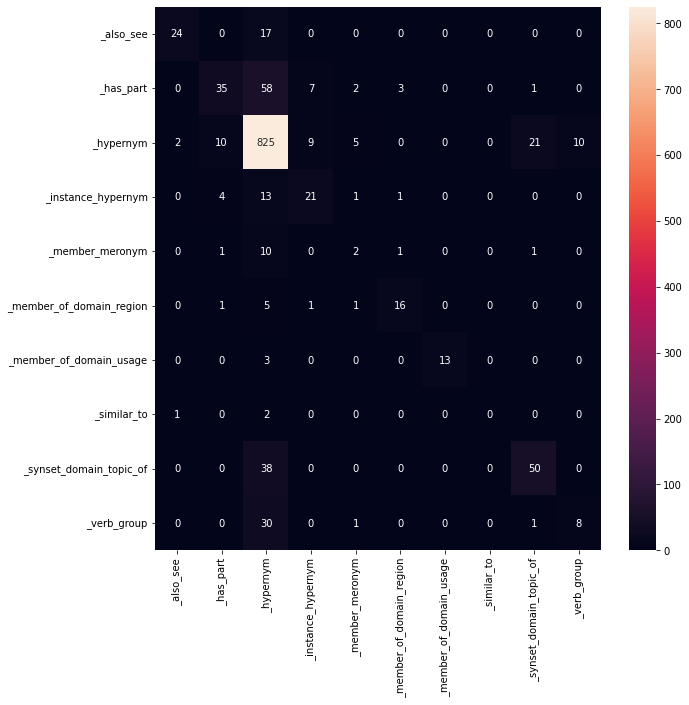

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(matrix, xticklabels=le.classes_, yticklabels=le.classes_, 
            annot=True, fmt='g')
plt.plot()

## FastText

In [ ]:
# fasttext.util.download_model('en', if_exists='ignore')  # English

In [ ]:
ft_model = fasttext.load_model('data/cc.en.300.bin')

In [ ]:
def apply_ft_model(ft_model, line, dim=300):
    result = np.zeros((300,))
    words = line.split(' ')

    for w in words:
        result += ft_model[w]
    
    return result / len(words)

In [ ]:
df_wn_train['word1_ft_embed'] = df_wn_train['clean_word1'].apply(lambda x: apply_ft_model(ft_model, x))
df_wn_train['word2_ft_embed'] = df_wn_train['clean_word2'].apply(lambda x: apply_ft_model(ft_model, x))

df_wn_valid['word1_ft_embed'] = df_wn_valid['clean_word1'].apply(lambda x: apply_ft_model(ft_model, x))
df_wn_valid['word2_ft_embed'] = df_wn_valid['clean_word2'].apply(lambda x: apply_ft_model(ft_model, x))

In [ ]:
df_wn_train.head()

,word1,relation,word2,clean_word1,clean_word2,relation_num,word1_ft_embed,word2_ft_embed
0,land_reform.n.01,_hypernym,reform.n.01,land reform,reform,2,"[-0.13526451960206032, -0.0022548986598849297,...","[-0.20145772397518158, -0.030789682641625404, ..."
3,kamet.n.01,_instance_hypernym,mountain_peak.n.01,kamet,mountain peak,3,"[-0.04110696166753769, 0.00899890623986721, 0....","[0.013494833023287356, 0.058841913007199764, -..."
6,hoist.v.03,_hypernym,raise.v.02,hoist,raise,2,"[0.02912253327667713, 0.0066508520394563675, -...","[0.002618613187223673, -0.06572853773832321, 0..."
7,empathy.n.01,_hypernym,sympathy.n.02,empathy,sympathy,2,"[-0.007713713683187962, -0.006120033096522093,...","[0.02586521953344345, 0.03214200958609581, 0.0..."
8,disengagement.n.02,_hypernym,retreat.n.01,disengagement,retreat,2,"[-0.05961097776889801, 0.002265043556690216, -...","[-0.03804107755422592, 0.02058837004005909, 0...."


In [ ]:
word1_embeds = np.stack(df_wn_train['word1_ft_embed'].values)
word2_embeds = np.stack(df_wn_train['word2_ft_embed'].values)
train_embeds = word1_embeds + word2_embeds

y_train = df_wn_train['relation_num'].values

In [ ]:
# word1_embeds = get_embeds_matrix(df_wn_valid, column='word1_w2v_embed', size=300)
# word2_embeds = get_embeds_matrix(df_wn_valid, column='word2_w2v_embed', size=300)
word1_embeds = np.stack(df_wn_valid['word1_ft_embed'].values)
word2_embeds = np.stack(df_wn_valid['word2_ft_embed'].values)
valid_embeds = word1_embeds + word2_embeds

y_valid = df_wn_valid['relation_num'].values

Predict

In [ ]:
logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(train_embeds, y_train)

train_preds = logreg.predict(train_embeds)
print('Train score:', accuracy_score(y_train, train_preds))

valid_preds = logreg.predict(valid_embeds)
print('Validation score:', accuracy_score(y_valid, valid_preds))

Train score: 0.8149159663865546
Validation score: 0.7970347648261759


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
matrix = confusion_matrix(y_valid, valid_preds)
matrix.diagonal() / matrix.sum(axis=1)

array([0.56097561, 0.44805195, 0.92674617, 0.58878505, 0.76556777,
       0.52941176, 0.72727273, 0.        , 0.58095238, 0.27906977])

In [ ]:
matrix

array([[  23,    0,   16,    0,    0,    0,    0,    0,    0,    2],
       [   0,   69,   62,   11,   11,    1,    0,    0,    0,    0],
       [   2,   12, 1088,    9,   27,    1,    2,    0,   28,    5],
       [   0,   10,   31,   63,    2,    0,    0,    0,    1,    0],
       [   0,    4,   56,    2,  209,    1,    0,    0,    1,    0],
       [   0,    9,    4,    3,    0,   18,    0,    0,    0,    0],
       [   0,    0,    6,    0,    0,    0,   16,    0,    0,    0],
       [   1,    0,    2,    0,    0,    0,    0,    0,    0,    0],
       [   0,    1,   39,    2,    2,    0,    0,    0,   61,    0],
       [   0,    0,   31,    0,    0,    0,    0,    0,    0,   12]])

[]

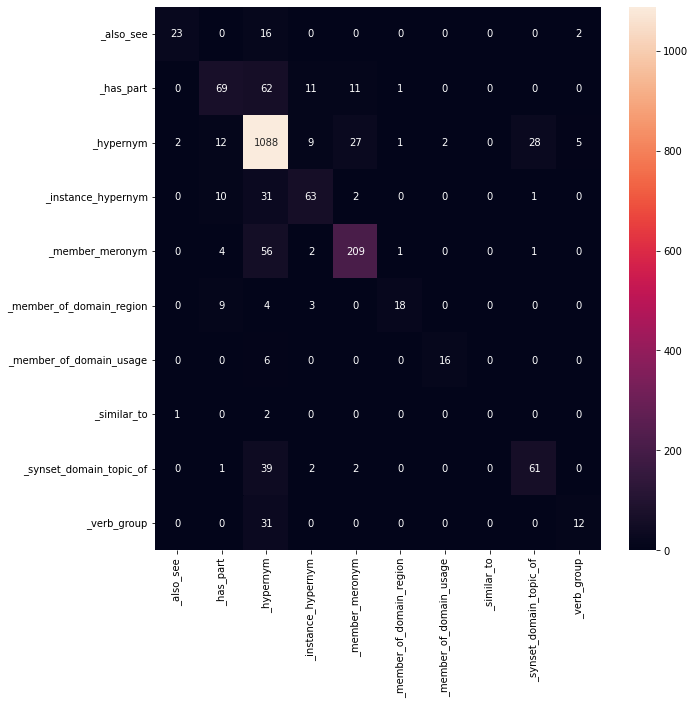

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(matrix, xticklabels=le.classes_, yticklabels=le.classes_, 
            annot=True, fmt='g')
plt.plot()

## GloVe

In [ ]:
# glove_emb = api.load('glove-wiki-gigaword-300')
# glove_emb.save_word2vec_format('glove_wikigiga.bin', binary=True)

In [ ]:
glove_model = gensim.models.KeyedVectors.load_word2vec_format('glove_wikigiga.bin', binary=True)

In [ ]:
df_wn_train['word1_glove_embed'] = df_wn_train['clean_word1'].apply(lambda x: apply_w2v(glove_model, x))
df_wn_train['word2_glove_embed'] = df_wn_train['clean_word2'].apply(lambda x: apply_w2v(glove_model, x))

df_wn_valid['word1_glove_embed'] = df_wn_valid['clean_word1'].apply(lambda x: apply_w2v(glove_model, x))
df_wn_valid['word2_glove_embed'] = df_wn_valid['clean_word2'].apply(lambda x: apply_w2v(glove_model, x))

In [ ]:
df_wn_train.isna().sum()

word1                   0
relation                0
word2                   0
clean_word1             0
clean_word2             0
relation_num            0
word1_ft_embed          0
word2_ft_embed          0
word1_glove_embed    9268
word2_glove_embed    5824
dtype: int64

In [ ]:
df_wn_train_glove = df_wn_train.dropna()
df_wn_valid_glove = df_wn_valid.dropna()

In [ ]:
# word1_embeds = get_embeds_matrix(df_wn_train, column='word1_w2v_embed', size=300)
# word2_embeds = get_embeds_matrix(df_wn_train, column='word2_w2v_embed', size=300)
word1_embeds = np.stack(df_wn_train_glove['word1_glove_embed'].values)
word2_embeds = np.stack(df_wn_train_glove['word2_glove_embed'].values)
train_embeds = word1_embeds + word2_embeds

y_train = df_wn_train_glove['relation_num'].values

In [ ]:
# word1_embeds = get_embeds_matrix(df_wn_valid, column='word1_w2v_embed', size=300)
# word2_embeds = get_embeds_matrix(df_wn_valid, column='word2_w2v_embed', size=300)
word1_embeds = np.stack(df_wn_valid_glove['word1_glove_embed'].values)
word2_embeds = np.stack(df_wn_valid_glove['word2_glove_embed'].values)
valid_embeds = word1_embeds + word2_embeds

y_valid = df_wn_valid_glove['relation_num'].values

Predict

In [ ]:
logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(train_embeds, y_train)

train_preds = logreg.predict(train_embeds)
print('Train score:', accuracy_score(y_train, train_preds))

valid_preds = logreg.predict(valid_embeds)
print('Validation score:', accuracy_score(y_valid, valid_preds))

Train score: 0.7987582094905072
Validation score: 0.7910349373764007


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
matrix = confusion_matrix(y_valid, valid_preds)
matrix.diagonal() / matrix.sum(axis=1)

array([0.51282051, 0.44827586, 0.93603412, 0.66981132, 0.6509434 ,
       0.63333333, 0.70588235, 0.        , 0.57608696, 0.31707317])

In [ ]:
matrix

array([[ 20,   0,  19,   0,   0,   0,   0,   0,   0,   0],
       [  0,  65,  64,  10,   1,   3,   0,   0,   2,   0],
       [  0,  13, 878,  10,  10,   1,   2,   0,  19,   5],
       [  0,  12,  21,  71,   1,   0,   0,   0,   1,   0],
       [  0,   3,  32,   1,  69,   1,   0,   0,   0,   0],
       [  0,   7,   3,   1,   0,  19,   0,   0,   0,   0],
       [  0,   0,   5,   0,   0,   0,  12,   0,   0,   0],
       [  1,   0,   2,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,  36,   1,   0,   1,   0,   0,  53,   0],
       [  1,   1,  26,   0,   0,   0,   0,   0,   0,  13]])

[]

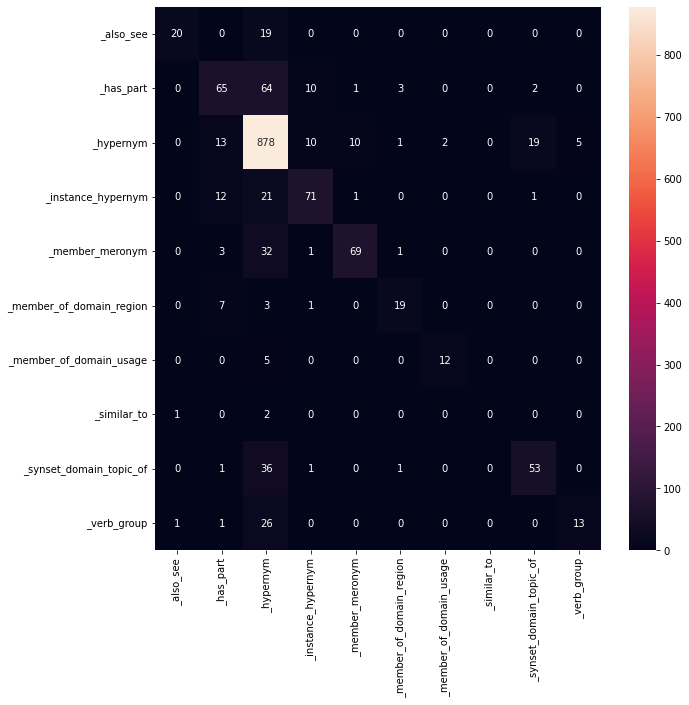

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(matrix, xticklabels=le.classes_, yticklabels=le.classes_, 
            annot=True, fmt='g')
plt.plot()

## ConceptNet Numberbatch

In [ ]:
!wget https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-en-19.08.txt.gz

--2022-04-13 15:18:09--  https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-en-19.08.txt.gz
Resolving conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)... 52.217.49.244
Connecting to conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)|52.217.49.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325403502 (310M) [application/x-gzip]
Saving to: ‘numberbatch-en-19.08.txt.gz’

numberbatch-en-19.0 100%[===================>] 310.33M  38.7MB/s    in 7.4s    

2022-04-13 15:18:17 (41.9 MB/s) - ‘numberbatch-en-19.08.txt.gz’ saved [325403502/325403502]



In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

In [ ]:
!gunzip numberbatch-en-19.08.txt.gz
conceptnet_model = load_embeddings("numberbatch-en-19.08.txt")

In [ ]:
df_wn_train['word1_cn_embed'] = df_wn_train['clean_word1'].apply(lambda x: apply_w2v(conceptnet_model, x))
df_wn_train['word2_cn_embed'] = df_wn_train['clean_word2'].apply(lambda x: apply_w2v(conceptnet_model, x))

df_wn_valid['word1_cn_embed'] = df_wn_valid['clean_word1'].apply(lambda x: apply_w2v(conceptnet_model, x))
df_wn_valid['word2_cn_embed'] = df_wn_valid['clean_word2'].apply(lambda x: apply_w2v(conceptnet_model, x))

In [ ]:
df_wn_train.isna().sum()

word1                 0
relation              0
word2                 0
clean_word1           0
clean_word2           0
relation_num          0
word1_w2v_embed    1112
word2_w2v_embed     774
word1_cn_embed     1112
word2_cn_embed      774
dtype: int64

In [ ]:
df_wn_train_conceptnet = df_wn_train.dropna()
df_wn_valid_conceptnet = df_wn_valid.dropna()

In [ ]:
# word1_embeds = get_embeds_matrix(df_wn_train, column='word1_w2v_embed', size=300)
# word2_embeds = get_embeds_matrix(df_wn_train, column='word2_w2v_embed', size=300)
word1_embeds = np.stack(df_wn_train_conceptnet['word1_cn_embed'].values)
word2_embeds = np.stack(df_wn_train_conceptnet['word2_cn_embed'].values)
train_embeds = word1_embeds + word2_embeds

y_train = df_wn_train_conceptnet['relation_num'].values

In [ ]:
# word1_embeds = get_embeds_matrix(df_wn_valid, column='word1_w2v_embed', size=300)
# word2_embeds = get_embeds_matrix(df_wn_valid, column='word2_w2v_embed', size=300)
word1_embeds = np.stack(df_wn_valid_conceptnet['word1_cn_embed'].values)
word2_embeds = np.stack(df_wn_valid_conceptnet['word2_cn_embed'].values)
valid_embeds = word1_embeds + word2_embeds

y_valid = df_wn_valid_conceptnet['relation_num'].values

Predict

In [ ]:
logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(train_embeds, y_train)

train_preds = logreg.predict(train_embeds)
print('Train score:', accuracy_score(y_train, train_preds))

valid_preds = logreg.predict(valid_embeds)
print('Validation score:', accuracy_score(y_valid, valid_preds))

Train score: 0.827767123783334
Validation score: 0.8090425531914893


In [ ]:
matrix = confusion_matrix(y_valid, valid_preds)
matrix.diagonal() / matrix.sum(axis=1)

In [ ]:
matrix

array([[  25,    0,   14,    0,    0,    0,    0,    0,    0,    2],
       [   0,   79,   58,    8,    2,    3,    0,    0,    0,    0],
       [   4,   12, 1047,    4,   24,    2,    1,    0,   28,    9],
       [   0,   13,   18,   66,    0,    0,    0,    0,    0,    0],
       [   0,    3,   57,    1,  201,    1,    0,    0,    1,    0],
       [   0,   11,    1,    1,    0,   18,    0,    0,    0,    0],
       [   0,    0,    5,    0,    0,    0,   15,    0,    0,    0],
       [   1,    0,    2,    0,    0,    0,    0,    0,    0,    0],
       [   0,    2,   37,    1,    0,    0,    0,    0,   60,    0],
       [   0,    0,   33,    0,    0,    0,    0,    0,    0,   10]])

[]

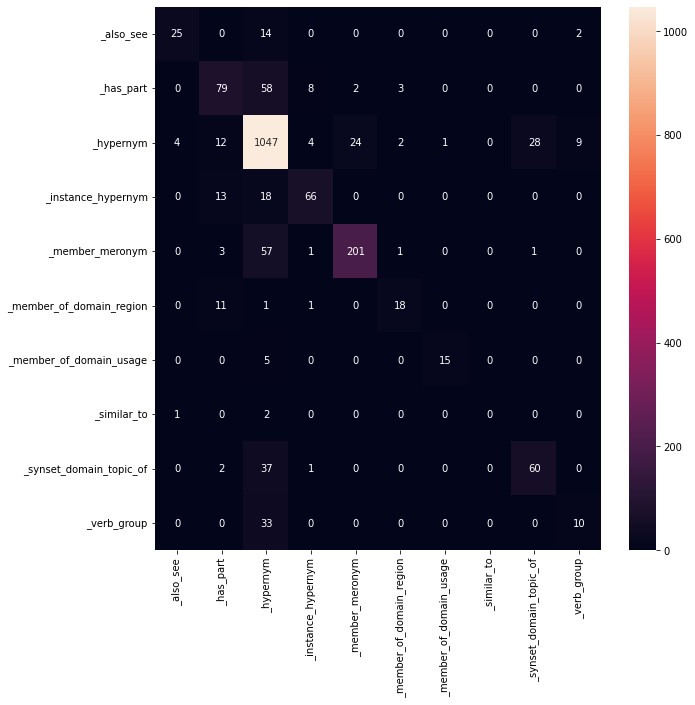

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(matrix, xticklabels=le.classes_, yticklabels=le.classes_, 
            annot=True, fmt='g')
plt.plot()

## BERT

In [ ]:
!pip install transformers -q

     |████████████████████████████████| 4.0 MB 12.8 MB/s 
     |████████████████████████████████| 596 kB 43.3 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
     |████████████████████████████████| 6.6 MB 37.0 MB/s 
     |████████████████████████████████| 895 kB 12.8 MB/s 


In [ ]:
from transformers import BertModel, BertTokenizer
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def apply_transformer_embed(model, x, device='cpu'):
    input_ids = torch.tensor(tokenizer.encode(x)).unsqueeze(0).to(device)
    outputs = model(input_ids)
    last_hidden_states = outputs[0]

    return last_hidden_states.mean(1).detach().cpu().numpy().squeeze(0)

In [ ]:
df_wn_train['word1_bert_embed'] = df_wn_train['clean_word1'].apply(lambda x: apply_transformer_embed(bert_model, x, device))
df_wn_train['word2_bert_embed'] = df_wn_train['clean_word2'].apply(lambda x: apply_transformer_embed(bert_model, x, device))

df_wn_valid['word1_bert_embed'] = df_wn_valid['clean_word1'].apply(lambda x: apply_transformer_embed(bert_model, x, device))
df_wn_valid['word2_bert_embed'] = df_wn_valid['clean_word2'].apply(lambda x: apply_transformer_embed(bert_model, x, device))

In [ ]:
# word1_embeds = get_embeds_matrix(df_wn_train, column='word1_w2v_embed', size=300)
# word2_embeds = get_embeds_matrix(df_wn_train, column='word2_w2v_embed', size=300)
word1_embeds = np.stack(df_wn_train['word1_bert_embed'].values)
word2_embeds = np.stack(df_wn_train['word2_bert_embed'].values)
train_embeds = word1_embeds + word2_embeds

y_train = df_wn_train['relation_num'].values

In [ ]:
# word1_embeds = get_embeds_matrix(df_wn_valid, column='word1_w2v_embed', size=300)
# word2_embeds = get_embeds_matrix(df_wn_valid, column='word2_w2v_embed', size=300)
word1_embeds = np.stack(df_wn_valid['word1_bert_embed'].values)
word2_embeds = np.stack(df_wn_valid['word2_bert_embed'].values)
valid_embeds = word1_embeds + word2_embeds

y_valid = df_wn_valid['relation_num'].values

Predict

In [ ]:
logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(train_embeds, y_train)

train_preds = logreg.predict(train_embeds)
print('Train score:', accuracy_score(y_train, train_preds))

valid_preds = logreg.predict(valid_embeds)
print('Validation score:', accuracy_score(y_valid, valid_preds))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train score: 0.8488970588235294
Validation score: 0.8353783231083844


In [ ]:
matrix = confusion_matrix(y_valid, valid_preds)
matrix.diagonal() / matrix.sum(axis=1)

array([0.58536585, 0.54545455, 0.92078365, 0.80373832, 0.85347985,
       0.67647059, 0.77272727, 0.        , 0.72380952, 0.23255814])

In [ ]:
matrix

array([[  24,    0,   16,    0,    0,    0,    0,    0,    0,    1],
       [   0,   84,   53,    9,    3,    4,    0,    0,    1,    0],
       [   3,   17, 1081,    8,   28,    1,    0,    0,   28,    8],
       [   0,    5,   13,   86,    2,    1,    0,    0,    0,    0],
       [   0,    2,   35,    0,  233,    1,    0,    0,    2,    0],
       [   0,    9,    0,    1,    1,   23,    0,    0,    0,    0],
       [   0,    0,    5,    0,    0,    0,   17,    0,    0,    0],
       [   2,    0,    1,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   28,    1,    0,    0,    0,    0,   76,    0],
       [   0,    0,   33,    0,    0,    0,    0,    0,    0,   10]])

[]

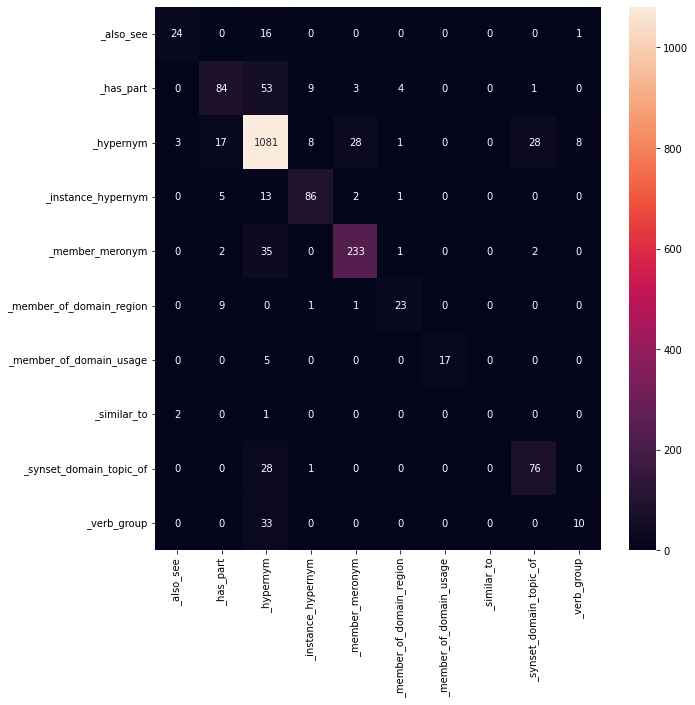

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(matrix, xticklabels=le.classes_, yticklabels=le.classes_, 
            annot=True, fmt='g')
plt.plot()